# 📝 Introduction to Text Mining and Natural Language Processing

## 📌 Assignment 1: Booking Scraping - Mini Research Project

### 👥 Authors:
- Viktoria Gagua  
- Alejandro Delgado Tello  
- Alex Malo  


### 📖 Table of Contents
[Required Packages](#required-packages)
### 1️⃣ Booking Scraper Engine
- 🔹 **[1.1 BookingBrowserEngine](#booking-browser-engine)**
- 🔹 **[1.2 BookingScrapper](#booking-scrapper)**

### 2️⃣ Data Parsing
- 🔹 **[2.1 BookingDataExtractor](#booking-data-extractor)**
- 🔹 **[2.2 Metadata](#metadata)**

### 3️⃣ Setting Up Browser Engine
- 🔹 **[3.1 Setting Up BookingBrowserEngine](#setup-booking-browser-engine)**

### 4️⃣ Scraping
- 🔹 **[4.1 Scraping Barcelona Booking Data](#treatment-data)**
- 🔹 **[4.2 Scraping Lisbon Booking Data](#control-data)**

### 5️⃣ Text Analysis
- 🔹 **[5.1 Pre-process the Hotel Description](#preprocessing-the-text)**
- 🔹 **[5.2 Creating Word Clouds](#creating-wordclouds)**

### 6️⃣ DiD Analysis
- 🔹 **[6.1 Exploring Data](#exploring-data)**
- 🔹 **[6.2 Welch's t-test](#welchs-t-test)**
- 🔹 **[6.3 Parallel Trend Analysis](#parallel-trend-analysis)**
- 🔹 **[6.4 Difference-in-Differences (DiD) Regression Model](#difference-in-differences-did-regression-model)**
- 🔹 **[6.5 Simple OLS Regression - Period](#1-impact-of-treatment-period)**
- 🔹 **[6.6 Simple OLS Regression - City](#2-impact-of-treatment-city)**
- 🔹 **[6.7 DiD Regression - Interaction Term](#3-difference-in-differences-did-model)**
- 🔹 **[6.8 Fixed Effects Regression](#4-fixed-effects-regression-model-no-additional-control-variables)**
- 🔹 **[6.9 Enhanced DiD Model with Amenities](#enhanced-did-model-with-additional-controls-for-amenities)**
- 🔹 **[6.10 Heterogenous Treatment Effects](#heterogenous-treatment-effects)**

## Required Packages

In [3]:
# Importing Packages
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException, StaleElementReferenceException
from selenium import webdriver
import os
import time
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import linearmodels.panel as panel

### Booking Browser Engine

In [2]:
class BookingBrowserEngine:
    """
    A web browser automation engine for navigating Booking.com using Firefox and Selenium.
    
    This class sets up and configures a Firefox browser instance for automated browsing.
    
    Methods:
    --------
    start_browser(download=True):
        Initializes and starts the Firefox browser instance with custom settings.
    
    __ffx_preferences(download=False):
        Configures Firefox preferences, such as file download behavior and the designated download folder.
    """
    
    def __init__(self, firefox_binary_path, dfolder, geko_path, link = 'https://www.booking.com/index.es.html'):
        self.firefox_binary_path = firefox_binary_path
        self.dfolder = dfolder
        self.geko_path = geko_path
        self.link = link
        
    def start_browser(self, download = True):
        """
        Initializes the Firefox browser with the given settings.
        """
        os.makedirs(self.dfolder, exist_ok=True)

        options = self.__ffx_preferences(download)

        service = Service(executable_path=self.geko_path)
        browser = webdriver.Firefox(service=service, options=options)
        
        # Open the target link
        browser.get(self.link)
        time.sleep(5)
        return browser 
    
    def __ffx_preferences(self, download=False):
        """
        Sets the preferences of the Firefox browser: download path.
        """
        options = Options()

        # Set the Firefox binary location
        if self.firefox_binary_path:
            options.binary_location = self.firefox_binary_path  

        # Set download folder preferences
        options.set_preference("browser.download.dir", self.dfolder)  # Predefine download folder
        options.set_preference("browser.download.folderList", 2)  # Use custom download folder
        options.set_preference("browser.download.manager.showWhenStarting", False)  # Disable popups
        options.set_preference("browser.helperApps.neverAsk.saveToDisk",
                            "application/msword,application/rtf,application/csv,text/csv,image/png,image/jpeg,application/pdf,text/html,text/plain,application/octet-stream")

        # Enable automatic PDF downloads
        if download:
            options.set_preference("browser.helperApps.neverAsk.saveToDisk", "application/pdf,application/x-pdf")
            options.set_preference("pdfjs.disabled", True)  # Disable built-in PDF viewer

        return options
    

### Booking Scrapper

In [3]:
class BookingScrapper:
    """
    A web scraper for extracting hotel metadata from Booking.com using Selenium.
    
    This class automates interactions with Booking.com, including searching for hotels
    in a specified city and date range, handling pop-ups, rejecting cookies, and scrolling 
    through search results.

    Methods:
    --------
    scrape_hotels_metadata_for_city(city, arrival_date, departure_date):
        Scrapes hotel metadata for a given city and date range.
    
    __change_language_selection():
        Changes the Booking.com language settings to English.
    
    __reject_cookies_if_exists():
        Attempts to reject cookie consent pop-ups if they appear.
    
    __fill_city_filter(city):
        Inputs the specified city into the search field.
    
    __fill_date_filter(arrival_date, departure_date):
        Selects the specified check-in and check-out dates.
    
    __filter():
        Applies search filters after entering search criteria.
    
    __close_genius_pop_up():
        Closes the Genius loyalty program pop-up if it appears.
    
    __scroll_to_page_bottom():
        Scrolls to the bottom of the page, clicking "Load More" if applicable.
    
    __check_and_click(xpath, type, timeout=10):
        Waits for an element to be clickable and attempts to click it.
    """
    
    def __init__(self, browser):
        self.browser = browser
        
    def scrape_hotels_metadata_for_city(self, city, arrival_date, departure_date):
        self.__change_language_selection()
        self.__reject_cookies_if_exists()
        
        # Finding "where are you going?" Button
        time.sleep(3)  # Wait for 3 seconds before clicking
        self.__fill_city_filter(city)
        self.__fill_date_filter(arrival_date, departure_date)
        self.__filter()
        
        self.__close_genius_pop_up()
        self.__scroll_to_page_bottom()
        booking_data_extractor = BookingDataExtractor(self.browser.page_source)
        return Metadata(booking_data_extractor.extract_hotels_metadata())
    
    def __change_language_selection(self):
        # Language selection
        self.browser.find_element(By.XPATH, '//button[@aria-controls="header_language_picker"]').click()
        # Selecting English
        self.browser.find_element(By.XPATH, '//span[@lang="en-us"]').click()
        
    def __reject_cookies_if_exists(self):
        success = self.__check_and_click("onetrust-reject-all-handler", "id", timeout=10)
        if success:
            print("Cookie consent rejected.")
        else:
            print("Failed to reject cookies.")
            
    def __fill_city_filter(self, city):
        self.browser.find_element(by=By.XPATH,value='//*[@id=":rh:"]').click()

        search1 = self.browser.find_element(by='xpath',value='//*[@id=":rh:"]')
        search1.send_keys(city)
    
    def __fill_date_filter(self, arrival_date, departure_date):       
        # Clicking the date box
        locator = '[data-testid="searchbox-dates-container"]'
        type = "css"
        success = self.__check_and_click(locator, type, timeout=10)
        if success:
            print("Clicked the dates box.")
        else:
            print("Failed to click the dates box.") 
        
        # Selecting May according to the current month when the code is run
        # Get the current month number (1 = January, 2 = February, ..., 12 = December)
        current_month = datetime.now().month

        # Calculate the number of clicks needed to reach May (month 5)
        clicks_needed = max(0, 5 - current_month)

        # Click the "Next month" button the required number of times
        for _ in range(clicks_needed):
            self.__check_and_click('//button[@class="a83ed08757 c21c56c305 f38b6daa18 d691166b09 f671049264 f4552b6561 dc72a8413c f073249358"]', "xpath")


        # Selecting the dates
        path='//div[@id="calendar-searchboxdatepicker"]//table[@class="eb03f3f27f"]//tbody//td[@class="b80d5adb18"]//span[@class="cf06f772fa ef091eb985"]'
        dates = self.browser.find_elements('xpath',path)

        for date in dates:
            if date.get_attribute("data-date") == f"2025-{arrival_date.split('-')[1]}-{arrival_date.split('-')[0]}":
                date.click()
            if date.get_attribute("data-date") == f"2025-{departure_date.split('-')[1]}-{departure_date.split('-')[0]}":
                date.click()
                break
    
    def __filter(self):
        self.browser.find_element(by=By.XPATH,value='//button[@class="a83ed08757 c21c56c305 a4c1805887 f671049264 a2abacf76b c082d89982 cceeb8986b b9fd3c6b3c"]').click()
    
    def __close_genius_pop_up(self):
        # Closing Genius Pop Up (if it appears)
        try:
            success = self.__check_and_click('//div[@class="eb33ef7c47"]//button[@class="a83ed08757 c21c56c305 f38b6daa18 d691166b09 ab98298258 f4552b6561"]', "xpath")
            if success:
                print("Pop-up closed.")
        except NoSuchElementException:
            print("Pop-up did not appear, continuing...")
            
        # Loading all results
        
    def __scroll_to_page_bottom(self):
        clicks = 0
        # Scrolling based on the height of the page.
        while True:
            try:
                total_height = self.browser.execute_script("return document.body.scrollHeight")
                scroll_position = (total_height * 10) - 200 
                #we scroll to the bottom of the page, and then back up a bit to reach the desired button
                self.browser.execute_script(f"window.scrollTo(0, {scroll_position});")

                # Attempt to click the "Load More" button using check_and_click.
                success = self.__check_and_click('//button[@class="a83ed08757 c21c56c305 bf0537ecb5 f671049264 af7297d90d c0e0affd09"]', "xpath", timeout=10)
                
                if not success:
                    break  # Exit loop if button is not found or not clickable.
                
                clicks += 1
            except Exception as e:
                print(f"Error while scrolling and clicking: {e}")
                break

        print(f"The 'Load More' button has been clicked {clicks} times")    
    
    def __check_and_click(self, xpath, type, timeout=10):
        '''
        This function returns:
        - True if click was successful.
        - False otherwise.
        '''
        try:
            wait = WebDriverWait(self.browser, timeout)
            
            if type.lower() == "xpath":
                element = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
            elif type.lower() == "id":
                element = wait.until(EC.element_to_be_clickable((By.ID, xpath)))
            elif type.lower() == "css":
                element = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, xpath)))
            elif type.lower() == "class":
                element = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, xpath)))
            elif type.lower() == "link":
                element = wait.until(EC.element_to_be_clickable((By.LINK_TEXT, xpath)))
            else:
                print(f"Unsupported locator type: {type}")
                return False
            
            element.click()
            
            return True
        
        except (ElementClickInterceptedException, NoSuchElementException, StaleElementReferenceException) as e:
            print(f"Error clicking element: {e}")
            return False
        except TimeoutException:
            print(f"Timeout: Element not clickable after {timeout} seconds: {xpath}")
            return False
        except Exception as e:
            print(f"Unexpected exception: {e}")
            return False


### Booking Data Extractor

In [4]:
class BookingDataExtractor:
    """
    A data extractor for retrieving hotel metadata from Booking.com search results.
    
    This class parses the page source using BeautifulSoup to extract relevant 
    hotel details, such as name, price, rating, and a link to the detailed hotel page.

    Methods:
    --------
    extract_hotels_metadata():
        Extracts metadata (name, price, rating, and link) for all hotels on the page 
        and returns the data in a pandas DataFrame.
    """
    
    def __init__(self, page_source):
        self.soup = BeautifulSoup(page_source, 'html.parser')
        
    def extract_hotels_metadata(self):
        # We will store each hotel metadata here   
        hotel_metadadata = []

        # This is our way to find all hotels from the soup
        hotels = self.soup.find_all('div', {'data-testid': 'property-card'})
        
        for hotel in hotels:
            # Extract hotel name
            name = hotel.find('div', {'data-testid': 'title'}).get_text(strip=True) if hotel.find('div', {'data-testid': 'title'}) else "NA"
            
            # Extract price
            price_unprocessed = hotel.find('span', {'class': 'f6431b446c fbfd7c1165 e84eb96b1f'}).get_text(strip=True) if hotel.find('span', {'class': 'f6431b446c fbfd7c1165 e84eb96b1f'}) else "NA"
            price = re.sub(r'\D', '', price_unprocessed)
            
            # Extract rating
            rating_box = hotel.find('div', {'data-testid': 'review-score'})
            rating = rating_box.find('div').get_text(strip=True)[-3:].replace(',', '.') if rating_box else "NA"

            # Extract link to detailed hotel page
            hotel_link = hotel.find('a', {'data-testid': 'title-link'})['href'] if hotel.find('a', {'data-testid': 'title-link'}) else None 
                    
            hotel_metadadata.append([name, price, rating, hotel_link])
        
        df = pd.DataFrame(hotel_metadadata, columns=['Name', 'Price', 'Rating', 'Hotel Link'])
        return df
    

### Metadata

In [5]:
class Metadata:
    """
    A class to manage and enhance hotel metadata extracted from Booking.com.
    
    This class allows for additional processing, such as scraping hotel descriptions
    from individual hotel detail pages using concurrent web requests.

    Methods:
    --------
    with_hotel_description():
        Scrapes additional hotel descriptions and appends them to the metadata DataFrame.
    
    get_dataframe():
        Returns the current metadata DataFrame.
    
    __scrape_hotel_description(detail_url):
        Retrieves the hotel description from the given Booking.com detail page.
    """
    
    def __init__(self, metadata):
        self.metadata = metadata
    
    def with_hotel_description(self):
        # Scrape each hotel's detailed page for additional information using ThreadPoolExecutor
        descriptions = []
        with ThreadPoolExecutor(max_workers=10) as executor:  # number of workers can be changed according to computer capabilities
            future_to_url = {executor.submit(self.__scrape_hotel_description, row['Hotel Link']): index for index, row in self.metadata.iterrows() if row['Hotel Link']}
            
            for future in future_to_url:
                index = future_to_url[future]
                try:
                    descriptions.append(future.result())
                except Exception as e:
                    print(f"Error processing hotel at index {index}: {e}")
                    descriptions.append("Error")
        
        # Ensure we maintain order by adding "NA" for hotels without links
        self.new_metadata = self.metadata.copy()
        self.new_metadata['Description'] = [descriptions.pop(0) if row['Hotel Link'] else "NA" for _, row in self.new_metadata.iterrows()]
        return Metadata(self.new_metadata)
    
    def get_dataframe(self):
        return self.metadata
    
    def __scrape_hotel_description(self, detail_url):
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        try:
            response = requests.get(detail_url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            
            description = soup.find('p', {'data-testid': 'property-description'}).get_text(strip=True) if soup.find('p', {'data-testid': 'property-description'}) else "NA"
            return description
        except Exception as e:
            print(f"Error scraping details from {detail_url}: {e}")
            return "Error"       


### Setup Booking Browser Engine

In [31]:
# Opening booking:
booking_browser_engine = BookingBrowserEngine(
    firefox_binary_path = "/Applications/Firefox.app/Contents/MacOS/firefox",
    dfolder = './downloads',
    geko_path = r"/Users/macbookpro/Desktop/Victoria/DSDM/Term2/NLP/NLP_GECKO/geckodriver"
)

## 🏁 Scraping

### Treatment Data

#### Scraping BCN Event Period data

In [32]:
barcelona_booking_scrapper = BookingScrapper(booking_browser_engine.start_browser())
barcelona_metadata_df = barcelona_booking_scrapper.scrape_hotels_metadata_for_city('Barcelona', '29-05-2025', '02-06-2025').with_hotel_description().get_dataframe()

# Save the DataFrame to a CSV file
barcelona_metadata_df.to_csv("./downloads/barcelona_hotel_data.csv", index=False)
print("Barcelona hotel data saved to barcelona_hotel_data.csv")


Cookie consent rejected.
Clicked the dates box.
Pop-up closed.
Timeout: Element not clickable after 10 seconds: //button[@class="a83ed08757 c21c56c305 bf0537ecb5 f671049264 af7297d90d c0e0affd09"]
The 'Load More' button has been clicked 37 times
Barcelona hotel data saved to barcelona_hotel_data.csv


#### Scraping BCN Pre-Event Period data

In [33]:
pre_event_barcelona_booking_scrapper = BookingScrapper(booking_browser_engine.start_browser())
pre_event_barcelona_metadata_df = pre_event_barcelona_booking_scrapper.scrape_hotels_metadata_for_city('Barcelona', '22-05-2025', '26-05-2025').with_hotel_description().get_dataframe()

# Save the DataFrame to a CSV file
pre_event_barcelona_metadata_df.to_csv("./downloads/pre_event_barcelona_hotel_data.csv", index=False)
print("Barcelona hotel data saved to pre_event_barcelona_hotel_data.csv")


Cookie consent rejected.
Clicked the dates box.
Pop-up closed.
Timeout: Element not clickable after 10 seconds: //button[@class="a83ed08757 c21c56c305 bf0537ecb5 f671049264 af7297d90d c0e0affd09"]
The 'Load More' button has been clicked 37 times
Barcelona hotel data saved to pre_event_barcelona_hotel_data.csv


### Control Data

#### Scraping Lisbon Event Period data

In [34]:
lisbon_booking_scrapper = BookingScrapper(booking_browser_engine.start_browser())
lisbon_metadata_df = lisbon_booking_scrapper.scrape_hotels_metadata_for_city('Lisbon', '29-05-2025', '02-06-2025').with_hotel_description().get_dataframe()

# Save the DataFrame to a CSV file
lisbon_metadata_df.to_csv("./downloads/lisbon_hotel_data.csv", index=False)
print("Lisbon hotel data saved to lisbon_hotel_data.csv")


Cookie consent rejected.
Clicked the dates box.
Pop-up closed.
Timeout: Element not clickable after 10 seconds: //button[@class="a83ed08757 c21c56c305 bf0537ecb5 f671049264 af7297d90d c0e0affd09"]
The 'Load More' button has been clicked 37 times
Lisbon hotel data saved to lisbon_hotel_data.csv


#### Scraping Lisbon Pre-Event Period data

In [36]:
pre_event_lisbon_booking_scrapper = BookingScrapper(booking_browser_engine.start_browser())
pre_event_lisbon_metadata_df = pre_event_lisbon_booking_scrapper.scrape_hotels_metadata_for_city('Lisbon', '22-05-2025', '26-05-2025').with_hotel_description().get_dataframe()

# Save the DataFrame to a CSV file
pre_event_lisbon_metadata_df.to_csv("./downloads/pre_event_lisbon_hotel_data.csv", index=False)
print("Lisbon hotel data saved to pre_event_lisbon_hotel_data.csv")


Cookie consent rejected.
Clicked the dates box.
Pop-up closed.
Timeout: Element not clickable after 10 seconds: //button[@class="a83ed08757 c21c56c305 bf0537ecb5 f671049264 af7297d90d c0e0affd09"]
The 'Load More' button has been clicked 37 times
Lisbon hotel data saved to pre_event_lisbon_hotel_data.csv


# Text Analysis

### Preprocessing the text

Removing Numbers (avoids unnecessary "2023", "100", etc.)

Adding Custom Stopwords (removes repetitive words like "hotel", "room")

Handling Empty Cases Better (returns an empty string instead of NaN)

In [4]:
# Download necessary NLTK resources (only required once)
nltk.download('stopwords')
nltk.download('punkt')

# Initialize Stemmer & Stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords (Optional, domain-specific)
custom_stopwords = {"hotel", "room", "stay", "night", "guest", "check", "booking", "property", "apartment"}
stop_words.update(custom_stopwords)

def clean_hotel_reviews(input_file, text_column="Description"):
    """
    Function to clean hotel reviews from a given CSV file.
    
    Parameters:
    - input_file (str): Path to the CSV file
    - text_column (str): Column name containing text to be cleaned (default: 'Description')

    Returns:
    - df (DataFrame): DataFrame with cleaned text column
    - Saves a cleaned version of the file with '_cleaned.csv' suffix
    """
    
    # Load dataset
    df = pd.read_csv(input_file)

    # Ensure the specified column exists
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the dataset!")

    # Text Preprocessing Function
    def preprocess_text(text):
        if pd.isna(text) or text.strip() == "":  # Handle missing or empty values
            return ""
        
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation and special characters
        text = re.sub(r"\b\d+\b", "", text)  # Remove numeric values
        words = word_tokenize(text)  # Tokenize words

        # Remove stopwords, apply stemming, and remove very short words
        words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]

        return " ".join(words)  # Reconstruct text

    # Apply preprocessing
    df[f'Cleaned_{text_column}'] = df[text_column].apply(preprocess_text)

    # Save cleaned data
    output_file = input_file.replace(".csv", "_cleaned.csv")
    df.to_csv(output_file, index=False)

    print(f"✅ Cleaned data saved as: {output_file}")
    
    return df  # Return the DataFrame for further analysis if needed


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
clean_hotel_reviews("./downloads/pre_event_barcelona_hotel_data.csv")
clean_hotel_reviews("./downloads/barcelona_hotel_data.csv")
clean_hotel_reviews("./downloads/pre_event_lisbon_hotel_data.csv")
clean_hotel_reviews("./downloads/lisbon_hotel_data.csv")

✅ Cleaned data saved as: ./downloads/pre_event_barcelona_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/barcelona_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/pre_event_lisbon_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/lisbon_hotel_data_cleaned.csv


,Name,Price,Rating,Hotel Link,Description,Cleaned_Description
0,Eurostars Universal Lisboa,855,8.7,https://www.booking.com/hotel/pt/eurostars-uni...,"Set in Lisbon, 600 metres from Lisbon Oceanari...",set lisbon metr lisbon oceanarium eurostar uni...
1,Locke de Santa Joana,922,8.8,https://www.booking.com/hotel/pt/locke-de-sant...,Locke de Santa Joana features accommodation lo...,lock santa joana featur accommod locat metr ce...
2,Universo Romantico,251,7.3,https://www.booking.com/hotel/pt/universo-roma...,Universo Romantico features accommodation situ...,universo romantico featur accommod situat metr...
3,Bica FLH Suites,928,9.1,https://www.booking.com/hotel/pt/feels-like-ho...,Bica FLH Suites is located in the historical c...,bica flh suit locat histor centr lisbon within...
4,Ibis Styles Lisboa Centro Liberdade NE,592,8.5,https://www.booking.com/hotel/pt/embaixador.ht...,Located 400 metres from Marques de Pombal Squa...,locat metr marqu pombal squar metro station ib...
...,...,...,...,...,...,...
991,Rostelbem Guesthouse Lisbon,272,7.3,https://www.booking.com/hotel/pt/rostelbem-gue...,Rostelbem Guesthouse Lisbon is situated conven...,rostelbem guesthous lisbon situat conveni lisb...
992,Mouraria's Place - Blue Studio,528,NaN,https://www.booking.com/hotel/pt/mourarias-pla...,Mouraria's Place - Blue Studio in Lisbon featu...,mouraria place blue studio lisbon featur accom...
993,Apartment Lisbon Airport,742,8.7,https://www.booking.com/hotel/pt/apartment-lis...,"Situated in Lisbon, Apartment Lisbon Airport o...",situat lisbon lisbon airport offer selfcat acc...
994,Solar dos Poetas,1386,9.0,https://www.booking.com/hotel/pt/solar-dos-poe...,"Ideally situated in Lisbon, Solar dos Poetas f...",ideal situat lisbon solar do poeta featur buff...


In [6]:
pre_ev_bcn_cleaned = clean_hotel_reviews("./downloads/pre_event_barcelona_hotel_data.csv")
bcn_cleaned = clean_hotel_reviews("./downloads/barcelona_hotel_data.csv")
pre_ev_lis_cleaned = clean_hotel_reviews("./downloads/pre_event_lisbon_hotel_data.csv")
lis_cleaned = clean_hotel_reviews("./downloads/lisbon_hotel_data.csv")

✅ Cleaned data saved as: ./downloads/pre_event_barcelona_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/barcelona_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/pre_event_lisbon_hotel_data_cleaned.csv
✅ Cleaned data saved as: ./downloads/lisbon_hotel_data_cleaned.csv


### Creating WordClouds

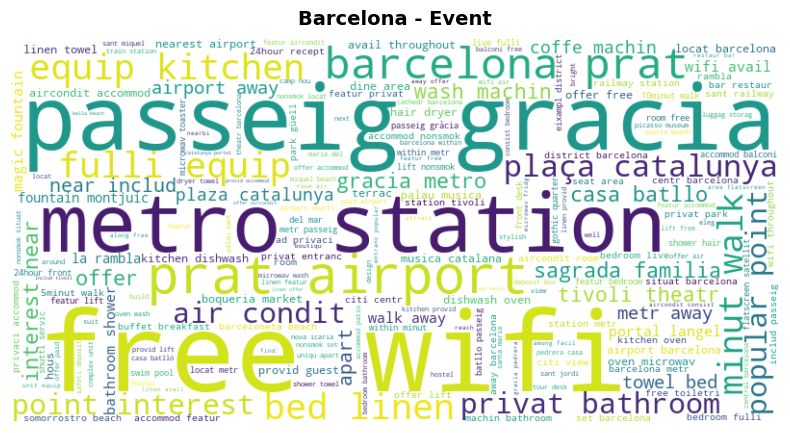

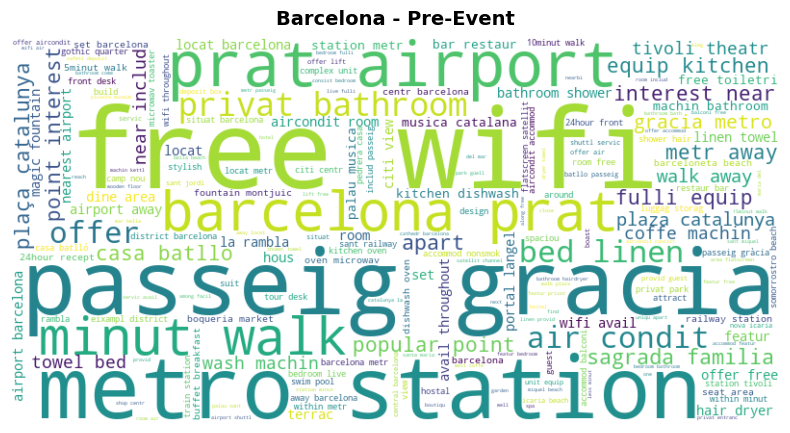

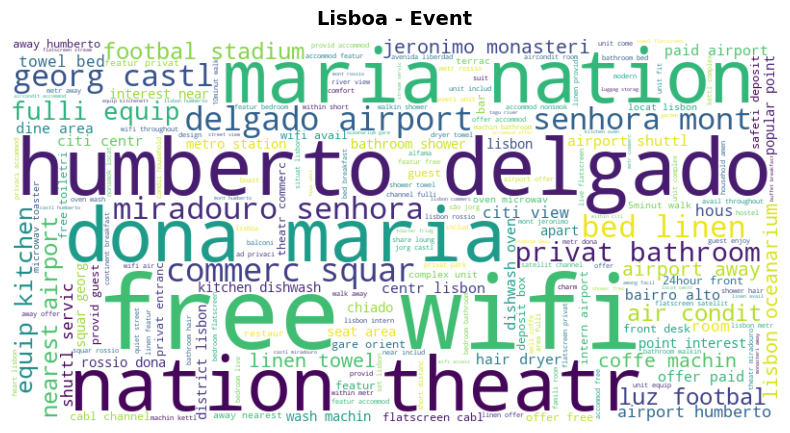

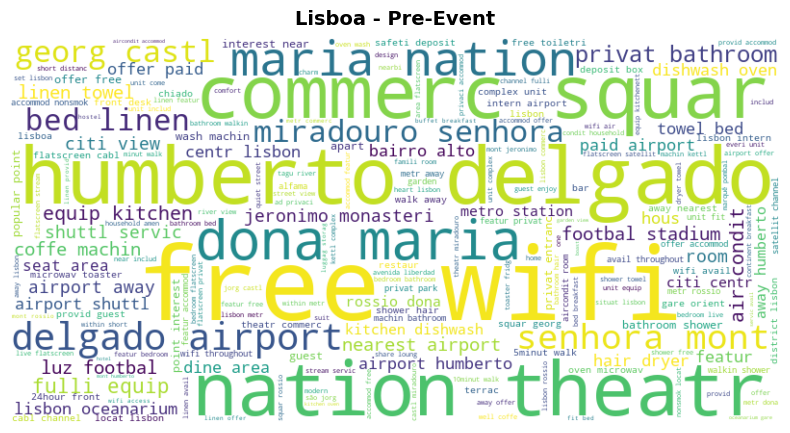

In [7]:
def generate_wordclouds(df, text_column="Cleaned_Description", location_column="Location", title=None):
    """
    Function to generate word clouds from a given DataFrame.
    """

    # Ensure the text column exists
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the dataset!")

    # Helper function to generate and display word cloud
    def plot_wordcloud(text, title):
        if not text.strip():  # Handle empty text cases
            print(f"⚠️ No text available for '{title}'")
            return

        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title, fontsize=14, fontweight='bold', pad=10)
        plt.show()

    # Generate word cloud for entire dataset
    all_text = " ".join(df[text_column].dropna())
    
    # Use custom title if provided, otherwise default to text_column name
    main_title = title if title else f"Overall Word Cloud - {text_column}"
    plot_wordcloud(all_text, main_title)

    # Generate Word Clouds Separately for Cities if location column exists
    if location_column in df.columns:
        for city in df[location_column].dropna().unique():
            city_text = " ".join(df[df[location_column] == city][text_column].dropna())
            city_title = f"Word Cloud - {city}" if not title else f"{title} - {city}"
            plot_wordcloud(city_text, city_title)

# Generate Word Clouds for each dataset
generate_wordclouds(bcn_cleaned, title="Barcelona - Event")
generate_wordclouds(pre_ev_bcn_cleaned, title="Barcelona - Pre-Event")
generate_wordclouds(lis_cleaned, title="Lisboa - Event")
generate_wordclouds(pre_ev_lis_cleaned, title="Lisboa - Pre-Event")


## Top 20 used words in Hotel descriptions

In [92]:
from collections import Counter

def get_top_words(df, text_column="Cleaned_Description", n=20):
    """
    Returns a list of tuples (word, frequency) of the top n words
    from the specified text_column in the DataFrame.
    """
    
    # Join all rows into a single string (only non-NaN entries)
    all_text = " ".join(df[text_column].dropna())
    
    # Split into individual words
    words = all_text.split()
    
    # Count frequencies
    freq_dist = Counter(words)
    
    return freq_dist.most_common(n)


In [93]:
# Top 20 words in Barcelona - Event
top_words_bcn = get_top_words(bcn_cleaned, text_column="Cleaned_Description", n=20)
print("Barcelona (Event) - Top 30 Words:")
for word, freq in top_words_bcn:
    print(f"{word}: {freq}")
    
print("\n" + "-"*50 + "\n")


Barcelona (Event) - Top 30 Words:
barcelona: 2169
free: 1132
offer: 1057
away: 980
featur: 951
airport: 939
wifi: 926
gracia: 891
passeig: 870
station: 867
metr: 804
room: 778
bathroom: 755
metro: 738
walk: 732
includ: 676
privat: 670
locat: 667
accommod: 616
prat: 612

--------------------------------------------------



In [94]:
# Top 20 words in Barcelona - Pre-Event
top_words_pre_bcn = get_top_words(pre_ev_bcn_cleaned, text_column="Cleaned_Description", n=20)
print("Barcelona (Pre-Event) - Top 30 Words:")
for word, freq in top_words_pre_bcn:
    print(f"{word}: {freq}")

print("\n" + "-"*50 + "\n")


Barcelona (Pre-Event) - Top 30 Words:
barcelona: 2099
free: 1164
offer: 1117
away: 1026
walk: 926
wifi: 906
metr: 896
room: 893
station: 858
airport: 847
featur: 836
bathroom: 815
gracia: 767
metro: 763
passeig: 758
minut: 708
includ: 684
locat: 683
privat: 653
apart: 652

--------------------------------------------------



In [95]:
# Top 20 words in Lisbon - Event
top_words_lis = get_top_words(lis_cleaned, text_column="Cleaned_Description", n=20)
print("Lisbon (Event) - Top 30 Words:")
for word, freq in top_words_lis:
    print(f"{word}: {freq}")

print("\n" + "-"*50 + "\n")


Lisbon (Event) - Top 30 Words:
lisbon: 1978
airport: 1428
offer: 1139
free: 1091
featur: 1087
away: 981
wifi: 903
bathroom: 862
rossio: 859
accommod: 821
room: 811
privat: 769
squar: 757
humberto: 753
delgado: 753
unit: 741
guest: 714
maria: 691
equip: 681
nation: 679

--------------------------------------------------



In [96]:
# Top 20 words in Lisbon - Pre-Event
top_words_pre_lis = get_top_words(pre_ev_lis_cleaned, text_column="Cleaned_Description", n=20)
print("Lisbon (Pre-Event) - Top 30 Words:")
for word, freq in top_words_pre_lis:
    print(f"{word}: {freq}")


Lisbon (Pre-Event) - Top 30 Words:
lisbon: 1894
airport: 1379
offer: 1176
free: 1083
featur: 1052
away: 982
wifi: 886
bathroom: 860
rossio: 834
room: 826
privat: 780
accommod: 779
unit: 747
squar: 747
humberto: 721
delgado: 721
guest: 720
area: 675
metr: 657
maria: 653


### Extract Hotel Amenities from Processed Text

In [8]:
def extract_hotel_amenities(input_csv, output_csv):
    """
    Extracts hotel amenities from preprocessed descriptions and saves the updated dataset.
    
    Parameters:
    input_csv (str): Path to the input CSV file (must contain 'Cleaned_Description' column).
    output_csv (str): Path to save the output CSV with amenities included.
    
    Output:
    Saves a CSV file with additional binary columns for each detected amenity.
    """
    # Load dataset
    df = pd.read_csv(input_csv)

    # Define common hotel amenities to search for
    amenities_list = ["pool", "spa", "gym", "parking", "wifi", "restaurant", 
                      "bar", "condit", "breakfast", "sea", "balcony"]

    # Function to check if an amenity appears in the hotel description
    def check_amenities(description, amenities):
        if pd.isna(description):  # Handle missing values
            return {amenity: 0 for amenity in amenities}
        found_amenities = {amenity: (1 if amenity in description else 0) for amenity in amenities}
        return found_amenities

    # Apply function to extract amenities
    amenities_df = df["Cleaned_Description"].apply(lambda x: check_amenities(str(x), amenities_list))

    # Convert dictionary results to DataFrame
    amenities_df = pd.DataFrame(amenities_df.tolist())

    # Merge amenities back to the original dataset
    df = pd.concat([df, amenities_df], axis=1)

    # Save the updated dataset
    df.to_csv(output_csv, index=False)

    print(f"✅ Amenities extracted and saved to {output_csv}")


In [9]:
extract_hotel_amenities("./downloads/barcelona_hotel_data_cleaned.csv", "./downloads/barcelona_hotel_data_with_amenities.csv")
extract_hotel_amenities("./downloads/lisbon_hotel_data_cleaned.csv", "./downloads/lisbon_hotel_data_with_amenities.csv")
extract_hotel_amenities("./downloads/pre_event_barcelona_hotel_data_cleaned.csv", "./downloads/pre_event_barcelona_hotel_data_with_amenities.csv")
extract_hotel_amenities("./downloads/pre_event_lisbon_hotel_data_cleaned.csv", "./downloads/pre_event_lisbon_hotel_data_with_amenities.csv")


✅ Amenities extracted and saved to ./downloads/barcelona_hotel_data_with_amenities.csv
✅ Amenities extracted and saved to ./downloads/lisbon_hotel_data_with_amenities.csv
✅ Amenities extracted and saved to ./downloads/pre_event_barcelona_hotel_data_with_amenities.csv
✅ Amenities extracted and saved to ./downloads/pre_event_lisbon_hotel_data_with_amenities.csv


# DiD Analysis

### Exploring Data

In [10]:
# Importing data from CSV files
barcelona_pre_ev = pd.read_csv("./downloads/pre_event_barcelona_hotel_data.csv")

barcelona_ev = pd.read_csv("./downloads/barcelona_hotel_data.csv")

lisbon_pre_ev = pd.read_csv("./downloads/pre_event_lisbon_hotel_data.csv")

lisbon_ev = pd.read_csv("./downloads/lisbon_hotel_data.csv")

In [11]:
# Counting rows in each DataFrame
print(f"Number of rows in Barcelona Pre Event Period: {barcelona_pre_ev.shape[0]}")
print(f"Number of rows in Barcelona Event Period: {barcelona_ev.shape[0]}")
print(f"Number of rows in Lisbon Pre Event Period: {lisbon_pre_ev.shape[0]}")
print(f"Number of rows in Lisbon Event Period: {lisbon_ev.shape[0]}")

Number of rows in Barcelona Pre Event Period: 999
Number of rows in Barcelona Event Period: 1001
Number of rows in Lisbon Pre Event Period: 975
Number of rows in Lisbon Event Period: 996


In [12]:
# Creating a treatment column
barcelona_pre_ev['treatment'] = 0
barcelona_ev['treatment'] = 1
lisbon_pre_ev['treatment'] = 0
lisbon_ev['treatment'] = 1

# Creating a City column
barcelona_pre_ev['barcelona'] = 1
barcelona_ev['barcelona'] = 1
lisbon_pre_ev['barcelona'] = 0
lisbon_ev['barcelona'] = 0

# Adding date column (22 May for pre-event, 29 May for event)
barcelona_pre_ev['Date'] = "2024-05-22"
barcelona_ev['Date'] = "2024-05-29"
lisbon_pre_ev['Date'] = "2024-05-22"
lisbon_ev['Date'] = "2024-05-29"

# Convert 'Date' to datetime format
for df in [barcelona_pre_ev, barcelona_ev, lisbon_pre_ev, lisbon_ev]:
    df['Date'] = pd.to_datetime(df['Date'])

# Concatenating the dataframes
combined_data = pd.concat([barcelona_pre_ev, barcelona_ev, lisbon_pre_ev, lisbon_ev], axis=0)

In [13]:
# Group by both treatment (event timing) and city (Barcelona vs. Lisbon)
average_prices_by_city = combined_data.groupby(['treatment', 'barcelona'])['Price'].mean().unstack()
# Renaming columns for better clarity
average_prices_by_city.columns = ['Lisbon', 'Barcelona']

# Display results
print("\nAverage Prices Before and During the Event by City:")
print(average_prices_by_city)


Average Prices Before and During the Event by City:
               Lisbon    Barcelona
treatment                         
0          981.211282  1127.868869
1          891.104418  1638.245754


### Welch's t-test


Welch’s t-test is used because hotel prices before and during the event likely have unequal variances, as some hotels may raise prices significantly while others remain stable. It also adjusts for unequal sample sizes, which is common when comparing different time periods. Since hotel prices can fluctuate and may not follow a normal distribution, Welch’s t-test provides a more robust and reliable statistical comparison than a standard t-test.

If p-value < 0.05 → The price difference is statistically significant, meaning that the event had a real impact on prices (not due to chance).

If p-value ≥ 0.05 → The price difference is not statistically significant, meaning that the event did not significantly impact hotel prices.

This will confirm whether Barcelona had a stronger price change compared to Lisbon, which is crucial for validating DiD approach.

In [14]:
from scipy import stats
# Performing Welch’s t-test
# Split data into groups
barcelona_pre_event = combined_data[(combined_data['barcelona'] == 1) & (combined_data['treatment'] == 0)]['Price']
barcelona_event = combined_data[(combined_data['barcelona'] == 1) & (combined_data['treatment'] == 1)]['Price']
lisbon_pre_event = combined_data[(combined_data['barcelona'] == 0) & (combined_data['treatment'] == 0)]['Price']
lisbon_event = combined_data[(combined_data['barcelona'] == 0) & (combined_data['treatment'] == 1)]['Price']

# Welch's t-test for Barcelona
t_stat_bcn, p_value_bcn = stats.ttest_ind(barcelona_pre_event, barcelona_event, equal_var=False)

# Welch's t-test for Lisbon
t_stat_lis, p_value_lis = stats.ttest_ind(lisbon_pre_event, lisbon_event, equal_var=False)

# Print results
print("\nWelch's t-test results:")
print(f"Barcelona: t-stat = {t_stat_bcn:.3f}, p-value = {p_value_bcn:.5f}")
print(f"Lisbon: t-stat = {t_stat_lis:.3f}, p-value = {p_value_lis:.5f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value_bcn < alpha:
    print("🔴 Significant difference in hotel prices in Barcelona before vs. during the event!")
else:
    print("🟢 No significant change in Barcelona hotel prices.")

if p_value_lis < alpha:
    print("🔴 Significant difference in hotel prices in Lisbon before vs. during the event!")
else:
    print("🟢 No significant change in Lisbon hotel prices.")



Welch's t-test results:
Barcelona: t-stat = -17.641, p-value = 0.00000
Lisbon: t-stat = 3.652, p-value = 0.00027
🔴 Significant difference in hotel prices in Barcelona before vs. during the event!
🔴 Significant difference in hotel prices in Lisbon before vs. during the event!


✅ Strong Evidence That the Event Affected Barcelona Prices

If only Barcelona’s prices increased while Lisbon’s prices dropped, this strongly suggests that the event caused the price spike in Barcelona.

This supports the validity of the Difference-in-Differences (DiD) model, as it shows Barcelona's price change is not just part of a general trend.

❌ Lisbon Prices Decreased – Not a Perfectly Stable Control
In an ideal DiD scenario, the control city (Lisbon) would stay stable over time.

Since Lisbon’s prices dropped, it suggests some other factors (e.g., lower demand, seasonality, economic conditions) affected Lisbon separately from the event.

**Implication**: The event caused Barcelona's prices to spike, but Lisbon may not be a perfect control since its prices declined instead of remaining stable.

plot pre-event trends to check if prices in Barcelona and Lisbon followed similar trends before the event

### Parallel Trend Analysis


Unique Cities: ['Lisbon' 'Barcelona']
Unique Treatment Periods: ['Before Event' 'During Event']
   treatment  barcelona        Price       City          Time
0          0          0   981.211282     Lisbon  Before Event
1          0          1  1127.868869  Barcelona  Before Event
2          1          0   891.104418     Lisbon  During Event
3          1          1  1638.245754  Barcelona  During Event


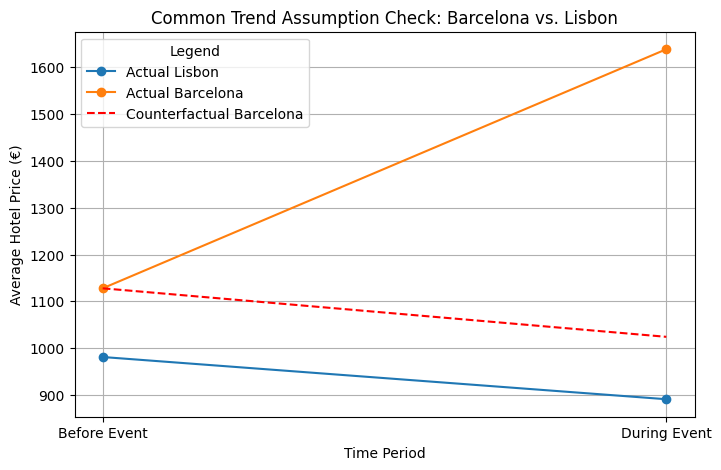

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate average price for each treatment period and city
avg_prices = combined_data.groupby(['treatment', 'barcelona'])['Price'].mean().reset_index()

# Rename values for clarity
avg_prices['City'] = avg_prices['barcelona'].map({0: 'Lisbon', 1: 'Barcelona'})
avg_prices['Time'] = avg_prices['treatment'].map({0: 'Before Event', 1: 'During Event'})

# Debugging: Print unique values to check if they exist
print("\nUnique Cities:", avg_prices['City'].unique())
print("Unique Treatment Periods:", avg_prices['Time'].unique())
print(avg_prices)  # Debugging: Show dataframe

# Ensure data exists before accessing it
def get_price(city, treatment):
    subset = avg_prices[(avg_prices['City'] == city) & (avg_prices['treatment'] == treatment)]
    if subset.empty:
        print(f"⚠️ Warning: No data for {city} during {'Before Event' if treatment == 0 else 'During Event'}!")
        return None
    return subset['Price'].values[0]

# Extract values safely
lisbon_prices_before = get_price('Lisbon', 0)
lisbon_prices_during = get_price('Lisbon', 1)

if lisbon_prices_before is None or lisbon_prices_during is None:
    raise ValueError("❌ Error: Missing data for Lisbon, cannot compute counterfactual trend.")

# Calculate Lisbon's percentage price change (Control Group Trend)
lisbon_price_change = (lisbon_prices_during - lisbon_prices_before) / lisbon_prices_before

# Extract Barcelona's price before event
barcelona_prices_before = get_price('Barcelona', 0)
if barcelona_prices_before is None:
    raise ValueError("❌ Error: Missing data for Barcelona before event.")

# Compute Barcelona's counterfactual price (if it followed Lisbon’s trend)
barcelona_counterfactual_during = barcelona_prices_before * (1 + lisbon_price_change)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot actual price trends for both cities
for city in avg_prices['City'].unique():
    subset = avg_prices[avg_prices['City'] == city]
    plt.plot(subset['treatment'], subset['Price'], marker='o', linestyle='-', label=f"Actual {city}")

# Plot counterfactual price trend for Barcelona
plt.plot([0, 1], [barcelona_prices_before, barcelona_counterfactual_during], linestyle='--', color='red', label="Counterfactual Barcelona")

# Customize the plot
plt.xlabel('Time Period')
plt.ylabel('Average Hotel Price (€)')
plt.title('Common Trend Assumption Check: Barcelona vs. Lisbon')
plt.xticks([0, 1], ['Before Event', 'During Event'])
plt.legend(title='Legend')
plt.grid(True)

# Show the plot
plt.show()


Again according to this visual we can state that:

✅ The actual prices in Barcelona increased sharply, while Lisbon’s prices decreased slightly, indicating that the event had a significant impact on Barcelona’s hotel prices. If the event had no effect, Barcelona’s prices would have followed the red dashed line, remaining relatively stable or slightly decreasing.

✅ The divergence between actual and counterfactual Barcelona prices suggests that the event led to a substantial price surge, while Lisbon (the control city) experienced a moderate price decline. This strengthens the case for a causal impact of the event on Barcelona’s hotel prices.

✅ However, since Lisbon’s prices declined instead of remaining stable, it may indicate other external factors affecting hotel prices, raising questions about whether Lisbon is a perfect control group for this Difference-in-Differences (DiD) analysis.

## Data Preparation for DiD Analysis

In [16]:
def merge_hotel_data(csv_files, output_file="merged_hotel_data.csv"):
    """
    Merges 4 cleaned hotel CSVs, assigning correct Date and City columns.

    - If filename contains "pre_event", assigns Date "2025-05-22".
    - Otherwise, assigns Date "2025-05-29".
    - If filename contains "barcelona", assigns City "Barcelona".
    - Otherwise, assigns City "Lisbon".

    Parameters:
    csv_files (list): List of file paths to the 4 input CSVs.
    output_file (str): Name of the output CSV file.

    Returns:
    pd.DataFrame: Merged DataFrame with Date and City columns added.
    """
    dataframes = []

    for file in csv_files:
        # Load CSV
        df = pd.read_csv(file)

        # Assign Date based on filename
        df['Date'] = "2025-05-22" if "pre_event" in file else "2025-05-29"

        # Assign City based on filename
        df['City'] = "Barcelona" if "barcelona" in file.lower() else "Lisbon"

        # Convert Date column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Append processed DataFrame to the list
        dataframes.append(df)

    # Combine all DataFrames into one
    merged_df = pd.concat(dataframes, ignore_index=True)

    # Save merged dataset
    merged_df.to_csv(output_file, index=False)

    print(f"✅ Merged {len(csv_files)} files into {output_file} with {merged_df.shape[0]} rows.")
    
    return merged_df

In [67]:

# Example usage with 4 input files
csv_files = [
    "./downloads/pre_event_barcelona_hotel_data_with_amenities.csv",
    "./downloads/barcelona_hotel_data_with_amenities.csv",
    "./downloads/pre_event_lisbon_hotel_data_with_amenities.csv",
    "./downloads/lisbon_hotel_data_with_amenities.csv"
]

# Saving the file
merged_df = merge_hotel_data(csv_files)

# Display first few rows
print(merged_df.head())


✅ Merged 4 files into merged_hotel_data.csv with 3971 rows.
                                                Name  Price  Rating  \
0                 The Central House Barcelona Gracia   1158     8.6   
1                             Sonder Paseo de Gracia   1315     8.2   
2                ibis Styles Barcelona City Bogatell    699     8.4   
3          Four Points by Sheraton Barcelona Airport    496     8.7   
4  Holiday Inn Express Barcelona City 22@, an IHG...    859     8.3   

                                          Hotel Link  \
0  https://www.booking.com/hotel/es/rodama3n-barc...   
1  https://www.booking.com/hotel/es/sonder-paseo-...   
2  https://www.booking.com/hotel/es/ibis-styles-b...   
3  https://www.booking.com/hotel/es/four-points-b...   
4  https://www.booking.com/hotel/es/express-by-ho...   

                                         Description  \
0  TCH Barcelona Grácia is within 100 metres of D...   
1  Well situated in Barcelona, Sonder Paseo de Gr...   
2  Locat

### Missing Values Treatment

In [68]:
# Display the number of missing values per column
missing_counts = merged_df.isnull().sum()

for column, count in missing_counts.items():
    print(f"{column}: {count} missing values")

Name: 0 missing values
Price: 0 missing values
Rating: 202 missing values
Hotel Link: 0 missing values
Description: 0 missing values
Cleaned_Description: 0 missing values
pool: 0 missing values
spa: 0 missing values
gym: 0 missing values
parking: 0 missing values
wifi: 0 missing values
restaurant: 0 missing values
bar: 0 missing values
condit: 0 missing values
breakfast: 0 missing values
sea: 0 missing values
balcony: 0 missing values
Date: 0 missing values
City: 0 missing values


In [69]:
# We will replace Rating missing values with 0
merged_df['Rating'] = merged_df['Rating'].fillna(0)

In [70]:
# Display the number of missing values per column
missing_counts = merged_df.isnull().sum()

for column, count in missing_counts.items():
    print(f"{column}: {count} missing values")

Name: 0 missing values
Price: 0 missing values
Rating: 0 missing values
Hotel Link: 0 missing values
Description: 0 missing values
Cleaned_Description: 0 missing values
pool: 0 missing values
spa: 0 missing values
gym: 0 missing values
parking: 0 missing values
wifi: 0 missing values
restaurant: 0 missing values
bar: 0 missing values
condit: 0 missing values
breakfast: 0 missing values
sea: 0 missing values
balcony: 0 missing values
Date: 0 missing values
City: 0 missing values


## Difference-in-Differences (DiD) Regression Model


### 📌 Explanation of Variables
### **Dependent Variable (What We Are Measuring)**
- **$ \text{Price}_{i,t} $** → **Hotel price** for hotel $ i $ at time $ t $ (our main outcome).

### **Independent Variables (Factors Affecting Price)**
✅ **DiD Variables:**
- **$ \text{Treatment}_i $ (Barcelona Dummy)** → **1 if the hotel is in Barcelona**, 0 if in Lisbon.
- **$ \text{Post}_t $ (Event Period Dummy)** → **1 if the date is in the F1 period (May 29 - June 2)**, 0 if before.
- **$ \text{Treatment}_i \times \text{Post}_t $ (Interaction Term)** → Measures the effect of F1 on hotel prices.

✅ **Control Variables:**
- **$ \text{Rating}_i $** → Number of **hotel stars** (higher = more expensive).
- **$ \text{Amenities}_i $** → **Count of Hotel amenities** (non-binary).
- **$ \gamma_i $ (Hotel Fixed Effects)** → Controls for **time-invariant hotel-specific characteristics**.
- **$ \delta_t $ (Time Fixed Effects)** → Controls for **general time trends** affecting both cities.
- **$ \varepsilon_{i,t} $ (Error Term)** → Captures randomness in pricing.

---

## Starting with Simple Regression Models

### 1) Impact of Treatment Period

$$
\text{price}_i = \beta_0 + \beta_1 \,\bigl(\text{Treatment\_period}_i\bigr) + \varepsilon_i
$$

In this model, $ \text{Treatment\_period}_i $ is a dummy variable equal to 1 if the observation falls on or after the specified treatment date (e.g., May 29, 2025), and 0 otherwise. The coefficient $\beta_1$ measures how much prices change, on average, after the treatment period begins, relative to the pre-treatment period.

---

In [71]:
# Create a binary indicator for the treatment period
df["treatment_period"] = (df["date"] >= "2025-05-29").astype(int)

# price = β₀ + β₁ * treatment_period + ϵ
model = smf.ols("price ~ treatment_period", data=df).fit(cov_type='HC1')

# summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     101.9
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           1.11e-23
Time:                        22:29:00   Log-Likelihood:                -31400.
No. Observations:                3971   AIC:                         6.280e+04
Df Residuals:                    3969   BIC:                         6.282e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1055.4316     11.093  

### 2) Impact of Treatment City

$$
\text{price}_i = \beta_0 + \beta_1 \,\bigl(\text{Treatment\_city}_i\bigr) + \varepsilon_i
$$

Here, $ \text{Treatment\_city}_i $ is a dummy variable equal to 1 if the hotel is in the treatment city (e.g., Barcelona) and 0 otherwise (e.g., Lisbon). The coefficient $\beta_1$ indicates the average price difference for hotels in the treatment city compared to the control city, before any treatment period begins.

---

In [72]:
# Create a binary variable for the treatment city
df["treatment_city"] = (df["city"] == "Barcelona").astype(int)

# β₀ + β₁ * treatment_city + ϵ
model = smf.ols("price ~ treatment_city", data=df).fit(cov_type='HC1')

# summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     507.4
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          7.80e-106
Time:                        22:29:05   Log-Likelihood:                -31212.
No. Observations:                3971   AIC:                         6.243e+04
Df Residuals:                    3969   BIC:                         6.244e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        935.6778     12.367     75.

### 3) Difference-in-Differences (DiD) Model

$$
\text{price}_i = \beta_0 
\;+\;\beta_1 \,\bigl(\text{Treatment\_period}_i\bigr)
\;+\;\beta_2 \,\bigl(\text{Treatment\_city}_i\bigr)
\;+\;\beta_3 \,\bigl(\text{Treatment\_period}_i \times \text{Treatment\_city}_i\bigr)
\;+\;\varepsilon_i
$$

In this model, $ \text{Treatment\_period}_i $ captures any overall price shift after the event date, $ \text{Treatment\_city}_i $ measures the baseline difference in the treatment city relative to the control city, and the interaction term $ \text{Treatment\_period}_i \times \text{Treatment\_city}_i $ is the difference-in-differences component that estimates how hotel prices in the treatment city change *relative* to the control city, over and above any common time trends or baseline city differences.

---

In [73]:
# 1. Create binary indicators for treatment city and treatment period
df['treatment_city'] = (df['city'] == 'Barcelona').astype(int)
df['treatment_period'] = (df['date'] >= '2025-05-29').astype(int)

# 2. Create the interaction term for the DiD
df['interaction'] = df['treatment_city'] * df['treatment_period']

# 3. price = β₀ + β₁(Treatment_period) + β₂(Treatment_city) + β₃(Interaction) + ϵ
model = smf.ols(
    formula="price ~ treatment_period + treatment_city + interaction",
    data=df
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     308.7
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          3.94e-180
Time:                        22:29:09   Log-Likelihood:                -31033.
No. Observations:                3971   AIC:                         6.207e+04
Df Residuals:                    3967   BIC:                         6.210e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          981.2113     19.208  

### 4) Fixed Effects Regression Model (No additional control variables)

$$
y_{it} = \alpha_i + \lambda_t + \beta \, (\text{Treatment}_i \times \text{Post}_t) + \varepsilon_{it}
$$


**Where:**

- $y_{it}$ is the price for hotel $i$ at time $t$.
- $\alpha_i$ is the hotel (entity) fixed effect capturing all time-invariant characteristics of hotel $i$.
- $\lambda_t$ is the time fixed effect capturing time-specific factors that affect all hotels.
- $\text{Treatment}_i$ is a dummy variable equal to 1 if hotel $i$ is in Barcelona (the treatment group), and 0 otherwise.
- $\text{Post}_t$ is a dummy variable equal to 1 for dates on/after May 29, 2025 (post-event period), and 0 for dates before.
- $(\text{Treatment}_i \times \text{Post}_t)$ is the interaction term (the difference-in-differences term) whose coefficient $\beta$ measures the treatment effect.
- $\varepsilon_{it}$ is the error term.


In [74]:
df = merged_df.copy()
df.columns = df.columns.str.lower()

# Convert Date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Define fixed effects (Hotel ID and Date)
df['hotel_id'] = df.groupby('name').ngroup()  # Assign a unique ID per hotel

# Define treatment variables
df['treatment'] = (df['city'] == 'Barcelona').astype(int)  # 1 if Barcelona, 0 if Lisbon
df['post'] = (df['date'] >= "2025-05-29").astype(int)  # 1 if event period, 0 otherwise
df['did'] = df['treatment'] * df['post']  # Interaction term

In [75]:
# Setting the index for panel data
df = df.set_index(['hotel_id', 'post'])

In [76]:
# Fixed Effects Model
model_1 = panel.PanelOLS.from_formula(
    "price ~ did + EntityEffects + TimeEffects",
    data=df
).fit()

# regression results
print(model_1.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.3090
Estimator:                   PanelOLS   R-squared (Between):              0.1401
No. Observations:                3971   R-squared (Within):               0.3826
Date:                Mon, Feb 03 2025   R-squared (Overall):              0.1377
Time:                        22:29:16   Log-likelihood                -2.396e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      593.92
Entities:                        2641   P-value                           0.0000
Avg Obs:                       1.5036   Distribution:                  F(1,1328)
Min Obs:                       1.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             593.92
                            

📌 The coefficient on the did term is about 332.51. This implies that, once the event starts, hotels in the treatment group (Barcelona) charge, on average, around €332 more relative to what we observe in the control group (Lisbon), above and beyond any baseline price differences or common time trends.

The 95% confidence interval ranges from about €306 to €359, suggesting we are very confident that the true treatment effect is within that range.

The p-value is 0.0000 (essentially less than 0.0001), indicating that the effect is statistically significant at any conventional level (e.g., 1%, 5%, or 10%). In other words, there is strong evidence that the event is associated with a real shift in prices, rather than being due to chance.

The R-squared of around 0.31 (or about 31%) means the model explains roughly one-third of the total variation in hotel prices across time and entities. In panel data settings, this is often considered quite reasonable, given that many unobservable factors can influence prices.

Taken together, these results strongly suggest that the Formula 1 has a large and significant impact on Barcelona hotel prices. Compared to Lisbon (the control group), Barcelona hotels will see their post-event prices increase substantially—by about €332 more than any price changes that would have happened absent the event.

---

## Creating control variables

In [77]:
# Create a single 'amenities_count' column that sums all amenity dummies
df['amenities_count'] = df[['pool', 'spa', 'gym', 'parking', 'wifi', 
                            'restaurant', 'bar', 'condit', 'breakfast', 
                            'sea', 'balcony']].sum(axis=1)


## Enhanced DiD model with additional controls for amenities

## Adding Amenities Variable from Hotel Description

$$
\text{price}_i = \beta_0 
\;+\; \beta_1\,(\text{treatment}_i) 
\;+\; \beta_2\,(\text{post}_i) 
\;+\; \beta_3\,(\text{did}_i)
\;+\; \beta_4\,(\text{amenities\_count}_i)
\;+\; \varepsilon_i
$$

where:

- $\text{price}_i$ is the dependent variable (the price of hotel $i$).
- $\text{treatment}_i$ is a dummy variable (1 if the hotel is in Barcelona, 0 otherwise).
- $\text{post}_i$ is a dummy variable (1 if the date is on/after May 29, 2025, 0 otherwise).
- $\text{did}_i$ is the interaction term ($\text{treatment}_i \times \text{post}_i$).
- $\text{amenities\_count}_i$ is the total number of listed amenities for hotel $i$.
- $\beta_0, \beta_1, \dots, \beta_4$ are the coefficients to be estimated.
- $\varepsilon_i$ is the error term.

📌 We chose treatment (indicating Barcelona versus Lisbon) and post (indicating before or after May 29, 2025) in order to capture a difference-in-differences setup, where did is the interaction term measuring how hotel prices in Barcelona change after the key date relative to Lisbon’s change. We also include the count of amenities to control for potential price differences arising from varying numbers of amenities offered by each hotel. The regression will tell us the estimated effect of the event (represented by did) on hotel prices, while holding constant the differences in the number of amenities. The amenities coefficient will show **how each additional amenity** correlates with hotel price, independently of the event effect.

In [78]:
# Define treatment variables
df['treatment'] = (df['city'] == 'Barcelona').astype(int)  # 1 if Barcelona, 0 if Lisbon
df['post'] = (df['date'] >= "2025-05-29").astype(int)       # 1 if event period, 0 otherwise
df['did'] = df['treatment'] * df['post']                    # Interaction term

# Fit the model, including 'rating'
model = smf.ols(
    "price ~ treatment + post + did + amenities_count + rating", 
    data=df
).fit(cov_type='HC1')

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     168.4
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          7.98e-163
Time:                        22:29:22   Log-Likelihood:                -30969.
No. Observations:                3971   AIC:                         6.195e+04
Df Residuals:                    3965   BIC:                         6.199e+04
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         722.5000     47.053     

📌 The “treatment” coefficient of approximately €53.86 indicates that in the pre-event period, Barcelona hotels are on average €53 more expensive than Lisbon hotels (holding the other variables constant). The large “did” coefficient of about €596.97 means that, on top of Barcelona’s baseline price difference, the post-event period in Barcelona is associated with an additional average increase of nearly €597, net of the broader drop signaled by the “post” coefficient. The “amenities_count” coefficient of about €88.49 indicates that each additional amenity is associated with an €88–€89 increase in a hotel’s price, controlling for everything else in the model. Overall, the R-squared of 0.215 suggests that the model explains about 21.5% of the variation in hotel prices, with the remaining variation due to other unobserved factors.

---

### Treatment effect by Hotel Quality (Using rating as a proxy)

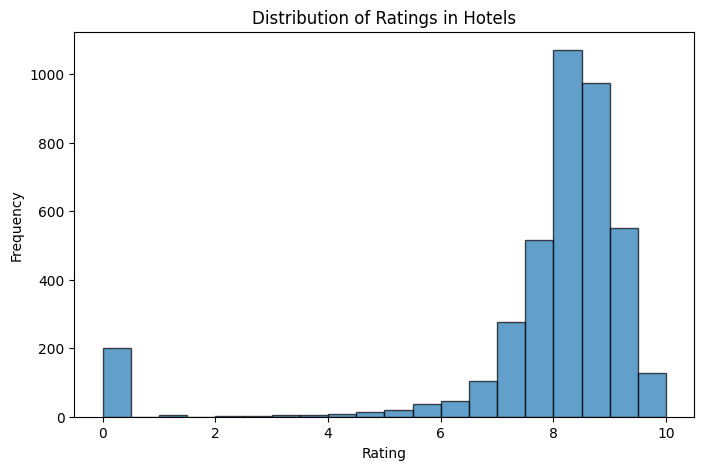

In [80]:
df = df.drop(columns="post") 
df_ols = df.reset_index()

# histogram
plt.figure(figsize=(8, 5))
plt.hist(df_ols['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings in Hotels")
plt.show()


## Heterogenous Treatment Effects

This regression lso includes a hotel’s rating and an interaction term between the DiD variable (`did`) and `rating`. By including `did:rating`, we allow the event’s effect on price to vary (“heterogeneous effects”) depending on each hotel’s rating. Higher-rated hotels, for instance, might see a different price impact from the event than lower-rated hotels.

$$
\text{price}_i 
= \beta_0 
+ \beta_1\,(\text{treatment}_i) 
+ \beta_2\,(\text{post}_i) 
+ \beta_3\,(\text{did}_i)
+ \beta_4\,(\text{rating}_i)
+ \beta_5\,(\text{did}_i \times \text{rating}_i)
+ \beta_6\,(\text{amenities\_count}_i)
+ \varepsilon_i
$$

- $\text{treatment}_i$ = 1 if hotel $i$ is in the treatment city (0 otherwise).  
- $\text{post}_i$ = 1 if date is on/after the event start (0 otherwise).  
- $\text{did}_i$ = $\text{treatment}_i \times \text{post}_i$.  
- $\text{rating}_i$ = the hotel's rating.  
- $\text{did}_i \times \text{rating}_i$ = the heterogeneous effect of the event, depending on rating.  
- $\text{amenities\_count}_i$ = total number of amenities offered by hotel $i$.  

In [81]:
# Model now includes a rating interaction term, that capture the possible heterogeneity in the effect of rating on price
model_4 = smf.ols(
    formula="price ~ treatment + post + did + rating + did:rating + amenities_count",
    data=df_ols
).fit(cov_type="HC1")

print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     185.1
Date:                Mon, 03 Feb 2025   Prob (F-statistic):          2.25e-208
Time:                        22:29:35   Log-Likelihood:                -30882.
No. Observations:                3971   AIC:                         6.178e+04
Df Residuals:                    3964   BIC:                         6.182e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         401.1917     33.897     

📌 This is very interesting regression model, because we are exploring heterogenous effects here. These results suggest that once the event (“did”) kicks in for the treatment city, lower-rated hotels experience a large jump in price, while higher-rated hotels in the treatment city see a more modest price increase. In particular, the large positive coefficient on did (about +€1586) indicates a strong event effect at a hypothetical rating of zero, but the negative interaction (did:rating ≈ –€130) means that each extra rating point reduces that large event-driven price boost. Hence, higher-rated hotels in Barcelona after the event still see a price increase but not as big as lower-rated hotels.

📌 Separately, the positive coefficient on rating (+€46) indicates that—outside of the event effect—each additional rating point (e.g., going from 7 to 8) is associated with a higher price. Likewise, the large positive effect of amenities_count (+€82) confirms that hotels offering more amenities tend to charge more. The treatment coefficient (+€50) shows that, even before the event, Barcelona hotels were already more expensive on average

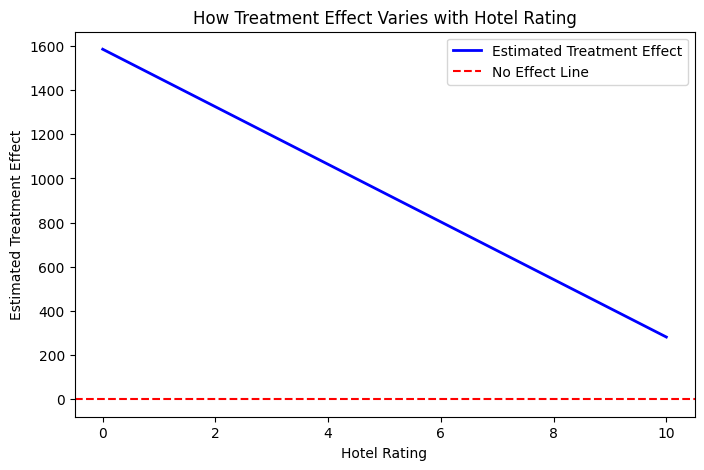

In [82]:
# Extract coefficients from previous
coef_did = model_4.params['did']
coef_did_rating = model_4.params['did:rating']

# Generate a range of hotel ratings (from min to max in dataset)
rating_values = np.linspace(df_ols['rating'].min(), df_ols['rating'].max(), 100)

# Calculate the estimated treatment effect for each rating value
estimated_treatment_effect = coef_did + coef_did_rating * rating_values

# Create a plot
plt.figure(figsize=(8, 5))
plt.plot(rating_values, estimated_treatment_effect, color='blue', linewidth=2, label="Estimated Treatment Effect")

# Highlight the zero effect line
plt.axhline(y=0, color='red', linestyle='--', label="No Effect Line")

# Labels and title
plt.xlabel("Hotel Rating")
plt.ylabel("Estimated Treatment Effect")
plt.title("How Treatment Effect Varies with Hotel Rating")
plt.legend()

# Show plot
plt.show()
